In [19]:
import os

key = os.getenv("OPENAI_API_KEY")
print("OPENAI_API_KEY is set:", bool(key))
print("Length:", len(key) if key else None)
print("Prefix:", key[:7] + "..." if key else None)  # optional: shows only first chars


OPENAI_API_KEY is set: True
Length: 164
Prefix: sk-proj...


In [20]:
from mlflow.genai import make_judge  # preferred in newer MLflow :contentReference[oaicite:2]{index=2}

gt_judge = make_judge(
    name="xr_config_quality_score",
    instructions=(
        "You are grading an IOS XR telemetry configuration.\n\n"
        "User request (inputs): {{ inputs }}\n\n"
        "Candidate config (outputs): {{ outputs }}\n\n"
        "Reference acceptable config (expectations): {{ expectations }}\n\n"
        "Score quality from 0.0 to 1.0.\n"
        "Hard requirements (must match): IP, port, transport (grpc no-tls), encoding.\n"
        "Be lenient about names, ordering, and sample-interval unless requested.\n"
        "Penalize only if sensor-paths are clearly unrelated.\n"
        "Do NOT output telemetry config. Do NOT output code. Keep any explanation extremely short."
    ),
    feedback_value_type=float,
    model="openai:/gpt-4.1-mini",
    inference_params={"temperature": 0, "max_tokens": 300},  # <-- was 10 (too small)
)


In [21]:
from dataclasses import dataclass
from typing import Any, Dict

@dataclass(frozen=True)
class RunCfg:
    vector_db: str
    top_k: int
    filter_fields: Dict[str, Any]
    temperature: float
    model_chat: str
    model_embed: str


In [ ]:
def make_grid(vector_dbs, top_ks, filters, temps, chat_models, embed_models):
    cfgs = []
    for vdb in vector_dbs:
        for k in top_ks:
            for ff in filters:
                for t in temps:
                    for cm in chat_models:
                        for em in embed_models:
                            cfgs.append(RunCfg(vdb, k, ff, t, cm, em))
    return cfgs

VECTOR_DBS = ["fixed_window_embeddings", "catalog_embeddings_improved"]  # add your 3rd
TOP_KS = [5, 10]
FILTERS = [{}]  # adjust to your payload schema,  {"protocol_tag": "bgp"}
TEMPS = [0,0.1,0.3]
CHAT_MODELS = ["gpt-4.1-nano", "gpt-4.1-mini"]
EMBED_MODELS = ["text-embedding-3-small"]

cfgs = make_grid(VECTOR_DBS, TOP_KS, FILTERS, TEMPS, CHAT_MODELS, EMBED_MODELS)
len(cfgs), cfgs[0]


(4,
 RunCfg(vector_db='catalog_embeddings', top_k=5, filter_fields={}, temperature=0.1, model_chat='gpt-4.1-mini', model_embed='text-embedding-3-small'))

In [23]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve().parents[0]  # repo root if cwd==repo/notebooks
sys.path.insert(0, str(ROOT / "src"))

In [24]:
from tracerag.rag.naive import naive_rag, build_openai_chat_fn
from tracerag.retrieval.qdrant import (
    QdrantRetrievalConfig,
    build_openai_embedding_fn,
    build_qdrant_retriever,
)

print("Imported tracerag modules OK.")


Imported tracerag modules OK.


In [25]:
@dataclass(frozen=True)
class RunCfg:
    vector_db: str                 # we'll map this to a Qdrant collection (or backend)
    top_k: int
    filter_fields: Dict[str, Any]  # e.g., {"domain":"bgp"} or {}
    temperature: float
    model_chat: str
    model_embed: str


In [26]:

from openai import OpenAI
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels

from typing import Any, Dict, List, Optional, Sequence, Tuple


In [27]:
def build_qdrant_filter(filter_fields: Dict[str, Any]) -> Optional[qmodels.Filter]:
    if not filter_fields:
        return None

    must: List[qmodels.FieldCondition] = []
    for key, value in filter_fields.items():
        must.append(
            qmodels.FieldCondition(
                key=key,
                match=qmodels.MatchValue(value=value),
            )
        )
    return qmodels.Filter(must=must)


In [28]:
def make_retriever(
    *,
    cfg: RunCfg,
    qdrant: QdrantClient,
    openai_client: OpenAI,
):
    embed_fn = build_openai_embedding_fn(openai_client, model=cfg.model_embed)

    q_filter = build_qdrant_filter(cfg.filter_fields)

    config = QdrantRetrievalConfig(
        collection_name=cfg.vector_db,  # <-- mapping: vector_db -> collection
        top_k=cfg.top_k,
        query_filter=q_filter,
    )

    qdrant_retriever = build_qdrant_retriever(
        qdrant=qdrant,
        embedding_fn=embed_fn,
        config=config,
    )

    # Return a function: retriever(query, k) -> List[Chunk]
    # Keep filter fixed per cfg (since filter_fields is a variation)
    return lambda query, k: qdrant_retriever(query, top_k=k, query_filter=q_filter)


def make_chat_fn(cfg: RunCfg, openai_client: OpenAI):
    return build_openai_chat_fn(
        openai_client,
        model=cfg.model_chat,
        temperature=cfg.temperature,
    )


In [29]:
SYSTEM_PROMPT_PATH = Path("../data/iosxr_prompt.txt")  # <-- your file
SYSTEM_PROMPT = SYSTEM_PROMPT_PATH.read_text(encoding="utf-8")

print("System prompt length:", len(SYSTEM_PROMPT))
print(SYSTEM_PROMPT[:300])


System prompt length: 1573
You are a Cisco IOS XR network engineer generating IOS XR 7.x model-driven telemetry configuration.

INPUTS:
- USER_REQUEST: describes the intent (e.g., “BGP telemetry”), destination IP/port, and optionally interval.
- CONTEXT: a list of valid YANG sensor-path candidates.

HARD RULES:
- Output ONLY 


In [30]:
def rag_predict_one(prompt: str, cfg: RunCfg, qdrant, openai_client) -> str:
    retriever = make_retriever(cfg=cfg, qdrant=qdrant, openai_client=openai_client)
    chat_fn = make_chat_fn(cfg, openai_client=openai_client)

    resp = naive_rag(
        user_query=prompt,
        retriever=retriever,
        chat_fn=chat_fn,
        system_prompt=SYSTEM_PROMPT,
        top_k=cfg.top_k,
        answer_instruction="Return only IOS XR telemetry configuration.",
    )
    return resp.answer


In [31]:
def build_eval_data(dataset_rows, cfg: RunCfg, qdrant, openai_client, max_examples=None):
    n = len(dataset_rows) if max_examples is None else min(len(dataset_rows), max_examples)
    eval_data = []

    for i in range(n):
        prompt = dataset_rows[i]["prompt"]
        reference = dataset_rows[i]["completion"]

        candidate = rag_predict_one(prompt, cfg, qdrant, openai_client)


#         eval_data.append({
#     "inputs": {"prompt": prompt},
#     "outputs": {"response": candidate},           # <-- change here
#     "expectations": {"expected_response": reference},
# })
    eval_data.append({
        "inputs": {"prompt": prompt},
        "outputs": {"response": candidate},
        "expectations": {"expected_response": reference},
    })

    return eval_data


In [32]:
import json
import mlflow

def run_one_cfg_mlflow(cfg: RunCfg, dataset_rows, qdrant, openai_client, max_examples=None):
    # log only your 6 variations
    mlflow.log_params({
        "vector_db": cfg.vector_db,
        "top_k": cfg.top_k,
        "filter_fields": json.dumps(cfg.filter_fields, sort_keys=True),
        "temperature": cfg.temperature,
        "model_chat": cfg.model_chat,
        "model_embed": cfg.model_embed,
    })

    eval_data = build_eval_data(dataset_rows, cfg, qdrant, openai_client, max_examples=max_examples)

    # MLflow judge
    results = mlflow.genai.evaluate(
        data=eval_data,
        scorers=[gt_judge],
    )

    # results.metrics usually contains aggregate metrics; but easiest is to also compute pass rate from the table
    # MLflow returns an EvaluationResult with a "tables" field in many setups.
    # We'll be defensive and compute ourselves:
    # Each row's result is stored in results.tables["evaluation_results"] or similar depending on version.
    return results


In [33]:
DATASET_PATH = Path("../data/judge_dataset.jsonl")  # <-- change if needed

def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

dataset = load_jsonl(DATASET_PATH)
print("Loaded rows:", len(dataset))
print("Example keys:", dataset[0].keys())
print("Prompt preview:\n", dataset[0]["prompt"][:200])
print("Completion preview:\n", dataset[0]["completion"][:200])


Loaded rows: 10
Example keys: dict_keys(['prompt', 'completion'])
Prompt preview:
 Generate Cisco IOS XR 7.0.1 telemetry configuration to monitor L2VPN xconnect/pseudowire operational state. Use gRPC with no TLS. Telemetry server address is 192.0.2.110 with port 57500. Choose releva
Completion preview:
 telemetry model-driven
 sensor-group L2VPN-XCONNECT-OPER
 sensor-path Cisco-IOS-XR-l2vpn-oper:l2vpnv2/active/xconnects
 sensor-path Cisco-IOS-XR-l2vpn-oper:l2vpnv2/active/pseudowires
 sensor-path Cisc


In [34]:
import random

random.seed(42)
dataset = random.sample(dataset, 10)

In [35]:
dataset

[{'prompt': 'Create telemetry model-driven configuration for Cisco IOS XR 7.0.1 to stream routing information base (RIB) summary and route counters (IPv4/IPv6). Use gRPC with no TLS. Telemetry server is 192.0.2.111 port 57500. Choose relevant sensor-paths.',
  'completion': 'telemetry model-driven\n sensor-group RIB-OPER\n sensor-path Cisco-IOS-XR-rib-oper:rib/vrfs/vrf/afi-safi/ipv4-unicast\n sensor-path Cisco-IOS-XR-rib-oper:rib/vrfs/vrf/afi-safi/ipv6-unicast\n sensor-path Cisco-IOS-XR-rib-oper:rib/summary\n !\n destination-group DG-RIB\n address-family ipv4\n destination 192.0.2.111\n port 57500\n encoding self-describing-gpb\n protocol grpc no-tls\n !\n subscription SUB-RIB\n sensor-group-id RIB-OPER sample-interval 60000\n destination-group-id DG-RIB\n !\n!'},
 {'prompt': 'Generate Cisco IOS XR 7.0.1 telemetry configuration to monitor L2VPN xconnect/pseudowire operational state. Use gRPC with no TLS. Telemetry server address is 192.0.2.110 with port 57500. Choose relevant sensor-pa

In [36]:
from qdrant_client import QdrantClient
from openai import OpenAI

mlflow.set_tracking_uri("file://" + str((Path.cwd() / "mlruns").resolve()))
mlflow.set_experiment("xr_rag_variations_judged")

qdrant = QdrantClient(host="localhost", port=6333)
openai_client = OpenAI()

with mlflow.start_run(run_name="parent_sweep") as parent:
    for cfg in cfgs:
        run_name = f"{cfg.vector_db}|k={cfg.top_k}|t={cfg.temperature}|chat={cfg.model_chat}|emb={cfg.model_embed}|f={cfg.filter_fields}"
        with mlflow.start_run(run_name=run_name, nested=True):
            results = run_one_cfg_mlflow(
                cfg=cfg,
                dataset_rows=dataset,
                qdrant=qdrant,
                openai_client=openai_client,
                max_examples=50,   # start small for iteration; remove later
            )
            print("DONE:", run_name)


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 11209b45d70e48bf8b2f45f1caa1483c

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 3bddd669edcb4afbb3075a4584489d5c

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:03, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 9fd1d0e23ca849d0a05bd49b9eb34a44

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 


✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: c1d5e9b993ab4fd2ab9dfffedbde2caf

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


In [44]:
eval_data = build_eval_data(dataset, cfg, qdrant, openai_client, max_examples=50)
results = mlflow.genai.evaluate(data=eval_data, scorers=[gt_judge])


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:03, Remaining: 00:00] 


✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: kindly-stag-643
  Run ID: 50a0dc9057304d6e950cd529af9c0c66

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.



In [46]:
eval_run_id = results.run_id  # <- key line (evaluation results live here)
traces = mlflow.search_traces(run_id=eval_run_id)

# Depending on MLflow version, traces may be list[dict] or a DataFrame-like object
import pandas as pd

df = pd.DataFrame(traces) if not isinstance(traces, pd.DataFrame) else traces
df.columns

Index(['trace_id', 'trace', 'client_request_id', 'state', 'request_time',
       'execution_duration', 'request', 'response', 'trace_metadata', 'tags',
       'spans', 'assessments'],
      dtype='object')

In [47]:
example = df.iloc[0].to_dict()
example.keys(), example.get("assessments")


(dict_keys(['trace_id', 'trace', 'client_request_id', 'state', 'request_time', 'execution_duration', 'request', 'response', 'trace_metadata', 'tags', 'spans', 'assessments']),
 [{'assessment_id': 'a-180e0fcd6a3f4798a38725dc1958443a',
   'assessment_name': 'xr_config_quality_score',
   'trace_id': 'tr-5c941cf0dc98d2c1e2acf72f9e574f7a',
   'span_id': '3139d32c93cd59bf',
   'source': {'source_type': 'LLM_JUDGE', 'source_id': 'openai:/gpt-4.1-mini'},
   'create_time': '2026-01-12T00:00:45.844Z',
   'last_update_time': '2026-01-12T00:00:45.844Z',
   'feedback': {'value': 0.7},
   'rationale': 'The candidate config correctly uses the specified IP (192.0.2.117), port (57500), transport (grpc no-tls), and encoding (self-describing-gpb), meeting the hard requirements. The sensor-paths are related to VRF operational data but use a different model (Cisco-IOS-XR-infra-rsi-cfg vs. infra-rsi-oper) and are more limited in scope. The candidate includes VRF state and route-targets, which are relevant, 

In [54]:
import mlflow
import pandas as pd

def traces_to_eval_df(traces):
    tdf = pd.DataFrame(traces) if not isinstance(traces, pd.DataFrame) else traces

    rows = []
    for _, r in tdf.iterrows():
        trace_id = r.get("trace_id")

        # request/response payloads (these are the inputs/outputs you passed)
        req = r.get("request") or {}
        resp = r.get("response") or {}

        # Try common shapes:
        # request: {"inputs": {"prompt": ...}} or directly {"prompt": ...}
        prompt = None
        if isinstance(req, dict):
            prompt = (req.get("inputs", {}) or {}).get("prompt") or req.get("prompt")

        # response: {"outputs": {"response": ...}} or {"response": ...}
        candidate = None
        if isinstance(resp, dict):
            candidate = (resp.get("outputs", {}) or {}).get("response") or resp.get("response")

        score = None
        rationale = None
        expected = None

        assessments = r.get("assessments") or []
        for a in assessments:
            name = a.get("assessment_name")
            if name == "xr_config_quality_score":
                fb = a.get("feedback") or {}
                score = fb.get("value")
                rationale = a.get("rationale")
            elif name == "expected_response":
                exp = a.get("expectation") or {}
                expected = exp.get("value")

        rows.append({
            "trace_id": trace_id,
            "prompt": prompt,
            "candidate": candidate,
            "expected": expected,
            "score": score,
            "rationale": rationale,
        })

    df = pd.DataFrame(rows)
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    return df

# --- Use it ---
eval_run_id = eval_run_id  # you already computed this earlier
traces = mlflow.search_traces(run_id=eval_run_id)
df = traces_to_eval_df(traces)

df.head(), df["score"].describe()


(                              trace_id  \
 0  tr-5c941cf0dc98d2c1e2acf72f9e574f7a   
 
                                               prompt  \
 0  Create Cisco IOS XR 7.0.1 telemetry model-driv...   
 
                                            candidate  \
 0  telemetry model-driven\n sensor-group VRF-OPER...   
 
                                             expected  score  \
 0  telemetry model-driven\n sensor-group VRF-OPER...    0.7   
 
                                            rationale  
 0  The candidate config correctly uses the specif...  ,
 count    1.0
 mean     0.7
 std      NaN
 min      0.7
 25%      0.7
 50%      0.7
 75%      0.7
 max      0.7
 Name: score, dtype: float64)

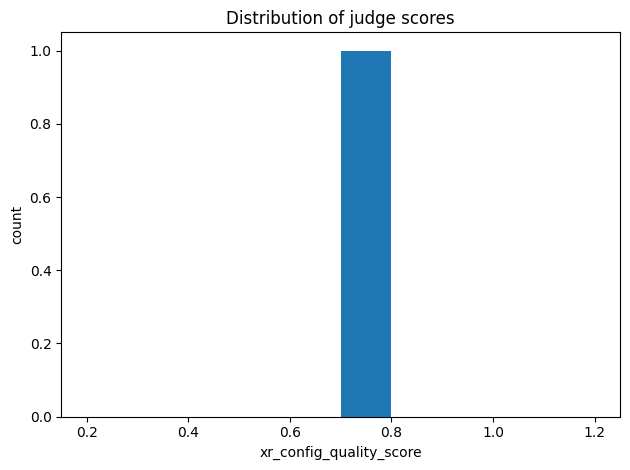

In [55]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["score"].dropna(), bins=10)
plt.xlabel("xr_config_quality_score")
plt.ylabel("count")
plt.title("Distribution of judge scores")
plt.tight_layout()
plt.show()


In [56]:
worst = df.sort_values("score").head(10)[["score", "prompt", "rationale", "trace_id"]]
worst


,score,prompt,rationale,trace_id
0,0.7,Create Cisco IOS XR 7.0.1 telemetry model-driv...,The candidate config correctly uses the specif...,tr-5c941cf0dc98d2c1e2acf72f9e574f7a


In [57]:
df.to_csv("per_example_eval.csv", index=False)
# If you ran a plot just before:
# plt.savefig("score_hist.png", dpi=200, bbox_inches="tight")
